# Principal Component Analysis (PCA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA, KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

## Principal Component Analysis (PCA)

Principal Component Analysis (PCA) เป็นวิธีการลด dimensionality ของข้อมูลวิธีหนึ่ง

<b>Principal component (PC)</b> คือ แกนที่มีทิศทางอยู่ในแนวที่ dataset มี variance มากที่สุด แต่ละแกนเกิดจาก linear combination ของแต่ละ feature และตั้งฉากซึ่งกันและกัน (PC แต่ละคู่จึงมี correlation เป็น 0)

$$PC_1 = a_{11}X_1 + a_{12}X_2 + a_{13}X_3$$
$$PC_2 = a_{21}X_1 + a_{22}X_2 + a_{23}X_3$$
$$PC_3 = a_{31}X_1 + a_{32}X_2 + a_{33}X_3$$

อันดับของ PC เรียงตามความสำคัญ (PC1 สำคัญที่สุด คือมี variance มากสุด)

เราจะใช้เฉพาะ PC ที่มี variance สูงเพื่อ represent ข้อมูลส่วนใหญ่ ทำให้
- dimensionality
- สูญเสีย information บางส่วน
- มี trade-off ระหว่างการเลือกจำนวน PC กับ model performance คือ ถ้าเอา PC มาใช้น้อย model จะมี performance ต่ำลง เราสามารถใช้ elbow method เพื่อดูว่าควรเลือก PC เท่าใด

<img src="../images/pca.png" width="700" /><br />

เราสามารถทำ PCA ได้โดยใช้ `sklearn.decomposition.PCA`

In [2]:
# Import data and drop duplicates
data = pd.read_csv('../data/penguins.csv').drop_duplicates()
data

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,species
0,-0.909073,0.819349,-1.444400,-0.573025,Adelie
1,-0.835598,0.163907,-1.082147,-0.509474,Adelie
2,-0.688650,0.466419,-0.430091,-1.208528,Adelie
3,-0.872335,1.777301,-0.792344,-0.700125,Adelie
4,-0.945810,0.365582,-1.444400,-0.731901,Adelie
...,...,...,...,...,...
320,0.578782,-1.701579,0.946471,0.920410,Gentoo
321,0.505308,-1.399067,1.018922,0.825084,Gentoo
322,1.166577,-0.693208,1.526076,1.968991,Gentoo
323,0.211411,-1.146975,0.801570,1.269937,Gentoo


In [3]:
# Features (X) and target (y)
X = data.drop(columns="species")
y = data["species"]
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=12)
# Encode the target
label_encoder = LabelEncoder().fit(y_train)
y_train = pd.Series(data=label_encoder.transform(y_train), name="species")
y_test = pd.Series(data=label_encoder.transform(y_test), name="species")

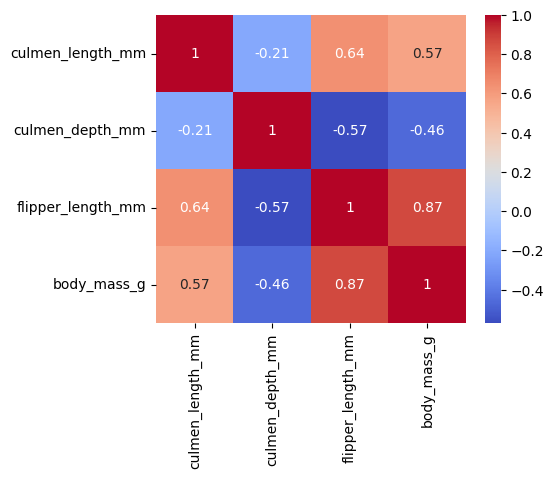

In [4]:
# Plot the correlation matrix of the original data
corr = X_train.corr().round(2)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(corr, cmap='coolwarm', ax=ax, annot=corr);

In [5]:
# Create a PCA model
pca = PCA(random_state=5).fit(X_train)

In [6]:
# PCs
PCs = pca.components_
pd.DataFrame(PCs.T,
             index=X_train.columns,
             columns=[f'PC{i}' for i in range(1, len(PCs)+1)])

,PC1,PC2,PC3,PC4
culmen_length_mm,0.440453,0.603124,0.644813,0.162661
culmen_depth_mm,-0.379465,0.794952,-0.440920,-0.172183
flipper_length_mm,0.585713,-0.001672,-0.200406,-0.785350
body_mass_g,0.564755,0.065494,-0.591306,0.571944


In [7]:
# Project data into the new PCA space
X_projected = pca.transform(X_train)
X_projected = pd.DataFrame(X_projected, columns=[f'PC{i}' for i in range(1, len(PCs)+1)])
X_projected

,PC1,PC2,PC3,PC4
0,-0.901394,0.085839,-0.338317,0.214005
1,-0.689737,0.483665,0.655917,0.209554
2,2.638389,0.030971,-0.173368,0.228922
3,-2.731550,-0.180849,0.160533,0.567401
4,-0.580401,0.245141,-0.450730,-0.348526
...,...,...,...,...
255,2.521258,-0.124581,0.245925,-0.426362
256,-2.000521,-2.076157,0.005553,-0.319857
257,2.209950,0.242032,-0.472449,-0.014738
258,2.668555,0.313754,-0.207394,-0.201763


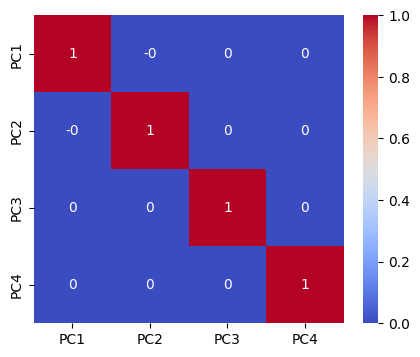

In [8]:
# Plot the correlation matrix of the projected data
corr = X_projected.corr().round(2)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(corr, cmap='coolwarm', ax=ax, annot=corr);

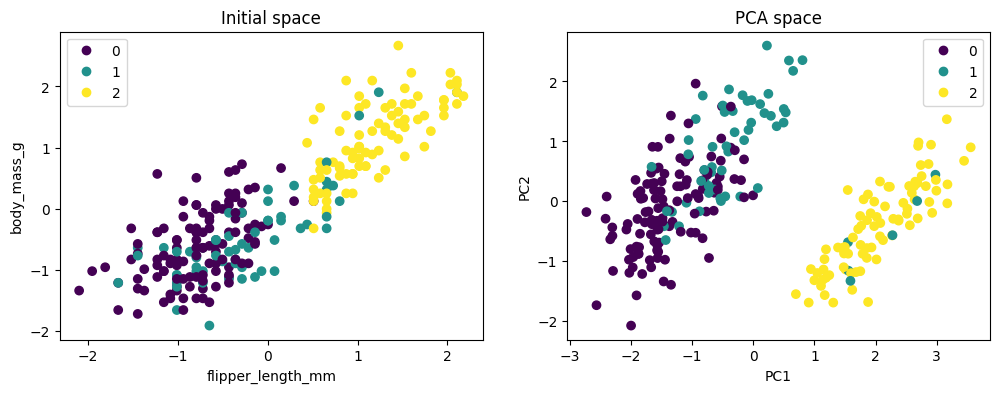

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# Plot data in 2D initial (flipper_length_mm - body_mass_g) space
scatter0 = axs[0].scatter(X_train.iloc[:, 2], X_train.iloc[:, 3], c=y_train, cmap='viridis')
axs[0].set(title='Initial space', xlabel='flipper_length_mm', ylabel='body_mass_g')
axs[0].legend(*scatter0.legend_elements())
# Plot data in 2D PCA (PC1 - PC2) spaces
scatter1 = axs[1].scatter(X_projected.iloc[:, 0], X_projected.iloc[:, 1], c=y_train, cmap='viridis')
axs[1].set(title='PCA space', xlabel='PC1', ylabel='PC2')
axs[1].legend(*scatter1.legend_elements());

In [10]:
# The variance ratio (variance of a PC / total variance of all PCs) of each PC
pca.explained_variance_ratio_

array([0.6843562 , 0.19162104, 0.09733816, 0.0266846 ])

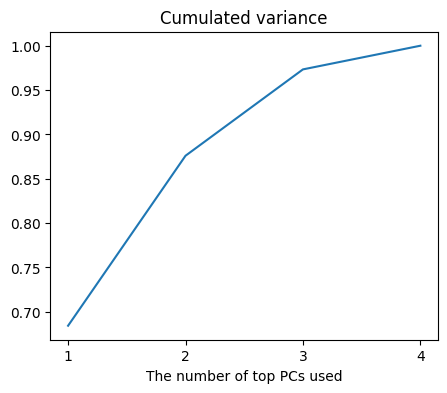

In [11]:
# Plot elbow curve
variance_ratios = pca.explained_variance_ratio_
n_components_range = range(1, len(pca.components_)+1)
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(n_components_range, np.cumsum(variance_ratios))
ax.set(
    xlabel='The number of top PCs used',
    title='Cumulated variance',
    xticks=n_components_range
);

In [12]:
# PCA fit with top 2 PCs
pca_compressed = PCA(n_components=2, random_state=5).fit(X_train)
len(pca_compressed.components_)

2

In [13]:
# Compress data
X_train_compressed = pca_compressed.transform(X_train)
X_test_compressed = pca_compressed.transform(X_test)

In [14]:
# KNN (K=8) fit with the compressed training set
knn_compressed = KNeighborsClassifier(n_neighbors=8).fit(X_train_compressed, y_train)

In [15]:
# Compute prediction accuracy on the compressed test set
y_pred = knn_compressed.predict(X_test_compressed)
accuracy_score(y_test, y_pred)

0.9384615384615385

## Kernel PCA (KPCA)

Captures non-linear patterns (similar principle to SVM kernels)

ทำได้โดยใช้ `sklearn.decomposition.KernelPCA`

In [16]:
# Create a KPCA model
kpca = KernelPCA(kernel='rbf', random_state=5).fit(X_train)

In [17]:
# Project data into the new PCA space
X_projected = kpca.transform(X_train)
n_components = len(X_projected[0])
X_projected = pd.DataFrame(X_projected, columns=[f'PC{i}' for i in range(1, n_components+1)])
X_projected

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC250,PC251,PC252,PC253,PC254,PC255,PC256,PC257,PC258,PC259
0,-0.472948,0.036411,0.010638,0.278048,-0.237727,0.127205,-0.093639,0.061512,-0.082170,-0.007455,...,-1.698244e-06,-2.119919e-05,-4.676465e-05,2.042923e-05,2.145721e-05,-2.121694e-05,1.396386e-05,1.775959e-06,8.529982e-05,4.530588e-05
1,-0.331052,0.431333,0.171752,-0.192034,-0.333927,-0.029347,-0.021743,0.011298,-0.025771,0.032862,...,4.239935e-05,-4.461222e-05,1.493010e-04,7.905004e-05,-2.140915e-05,9.235986e-06,1.711671e-05,2.016978e-05,5.580999e-06,-1.586915e-06
2,0.736673,-0.117006,-0.407083,-0.098107,-0.134878,-0.011951,-0.049234,-0.087213,0.010671,0.042952,...,-4.774727e-06,-2.687021e-05,3.857885e-06,4.941159e-06,-2.516506e-06,-9.537393e-08,-1.859834e-06,-1.746184e-08,-8.910695e-07,-2.506871e-07
3,-0.338564,-0.323789,-0.090210,-0.203574,0.151121,-0.446815,-0.195934,0.157097,0.035015,-0.148271,...,-7.363475e-07,8.667590e-08,-4.875020e-07,-7.612345e-07,-1.880152e-07,4.389697e-08,-2.053147e-07,7.513876e-09,-5.044990e-08,-5.392008e-08
4,-0.356367,0.175494,0.008366,0.346067,-0.137532,0.312369,0.071291,-0.126871,0.024676,-0.072368,...,-2.735570e-06,1.019634e-05,-5.560093e-06,-9.869225e-06,3.869982e-07,4.919456e-06,7.225796e-06,5.814608e-06,3.174675e-06,7.791331e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,0.718900,-0.106216,-0.221847,-0.059782,-0.065615,-0.055995,0.026116,-0.089571,-0.132344,-0.166311,...,-5.916347e-06,-6.688019e-06,1.242626e-06,6.827197e-07,1.897681e-06,1.299946e-06,-3.979600e-07,-3.717975e-07,-5.344691e-08,-1.047692e-07
256,-0.184715,-0.393210,0.002778,-0.337335,0.449122,0.232047,-0.005497,0.112959,0.189439,0.193858,...,6.778396e-08,1.077115e-07,3.587532e-07,1.968871e-07,-7.819369e-08,2.157928e-07,1.197460e-07,-3.933035e-08,-5.516154e-08,1.303761e-08
257,0.704430,-0.055895,-0.391653,-0.060707,-0.112372,0.101130,-0.100996,-0.049208,0.027606,-0.023662,...,-1.171293e-05,-2.830542e-06,3.341621e-06,4.916890e-07,-1.504368e-06,-1.706223e-06,-3.595803e-07,1.373000e-06,1.709816e-07,-1.369608e-08
258,0.696018,-0.087235,-0.499881,-0.139240,-0.116132,0.036521,0.080696,0.024566,-0.087128,-0.090478,...,-1.110050e-04,-5.351661e-05,7.569521e-06,3.941364e-06,2.417536e-06,2.540602e-06,-5.360623e-06,-1.200519e-06,-2.846433e-06,-5.064591e-07


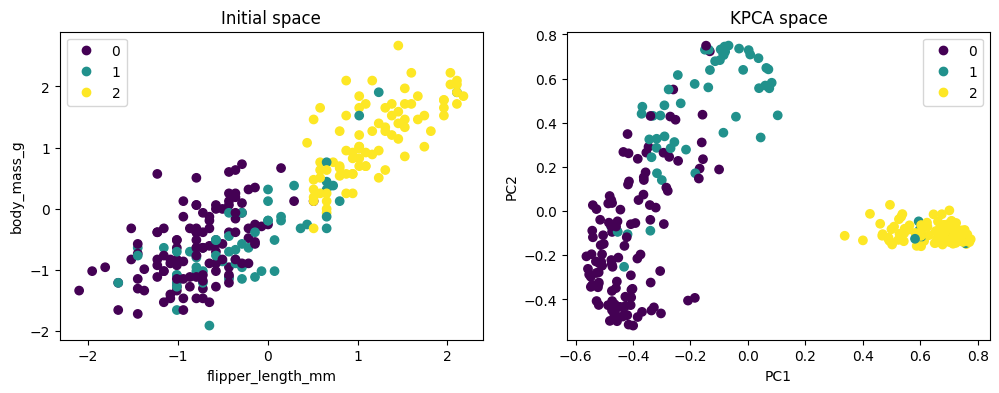

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# Plot data in 2D initial (flipper_length_mm - body_mass_g) space
scatter0 = axs[0].scatter(X_train.iloc[:, 2], X_train.iloc[:, 3], c=y_train, cmap='viridis')
axs[0].set(title='Initial space', xlabel='flipper_length_mm', ylabel='body_mass_g')
axs[0].legend(*scatter0.legend_elements())
# Plot data in 2D KPCA (PC1 - PC2) spaces
scatter1 = axs[1].scatter(X_projected.iloc[:, 0], X_projected.iloc[:, 1], c=y_train, cmap='viridis')
axs[1].set(title='KPCA space', xlabel='PC1', ylabel='PC2')
axs[1].legend(*scatter1.legend_elements());

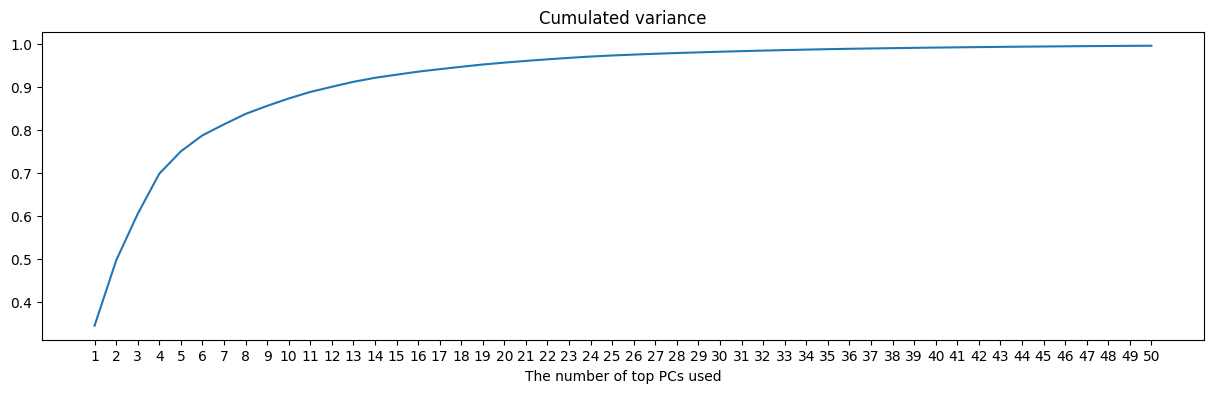

In [19]:
# Plot elbow curve (".explained_variance_ratio_" is not available)
variance_ratios = X_projected.std()**2 / (X_projected.std()**2).sum()
n_components_range = range(1, 51)
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(n_components_range, np.cumsum(variance_ratios[:50]))
ax.set(
    xlabel='The number of top PCs used',
    title='Cumulated variance',
    xticks=n_components_range
);

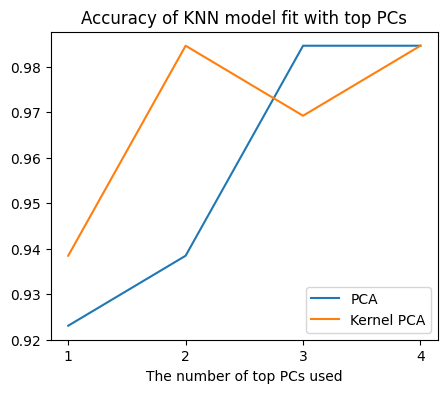

In [20]:
# Plot trade-off curve between the number of top PCs used and
# the accuracy of KNN model fit with the top PCs

accuracy_from_pca, accuracy_from_kpca = [], []
n_components_range = range(1, len(pca.components_)+1)
for i in n_components_range:
    # PCA and kernel PCA with top 'i' PCs
    pca_compressed = PCA(n_components=i, random_state=5).fit(X_train)
    kpca_compressed = KernelPCA(kernel='rbf', n_components=i, random_state=5).fit(X_train)
    # KNN (K=8) fit with the compressed training set
    knn_compressed_by_pca = \
        KNeighborsClassifier(n_neighbors=8).fit(pca_compressed.transform(X_train), y_train)
    knn_compressed_by_kpca = \
        KNeighborsClassifier(n_neighbors=8).fit(kpca_compressed.transform(X_train), y_train)
    # Compute prediction accuracy on the compressed test set
    y_pred_from_pca = knn_compressed_by_pca.predict(pca_compressed.transform(X_test))
    y_pred_from_kpca = knn_compressed_by_kpca.predict(kpca_compressed.transform(X_test))
    accuracy_from_pca.append(accuracy_score(y_test, y_pred_from_pca))
    accuracy_from_kpca.append(accuracy_score(y_test, y_pred_from_kpca))

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(n_components_range, accuracy_from_pca, label="PCA")
ax.plot(n_components_range, accuracy_from_kpca, label="Kernel PCA")
ax.set(
    xlabel='The number of top PCs used',
    title='Accuracy of KNN model fit with top PCs',
    xticks=n_components_range
)
ax.legend();

## Decompressing PCA

เราสามารถแปลงข้อมูลใน PCA space กลับมาอยู่ใน initial space ได้ แต่จะสูญเสีย information บางส่วน

In [21]:
# Compress data using top 2 components
pca_compressed = PCA(n_components=2, random_state=5).fit(X_train)
X_train_compressed = pca_compressed.transform(X_train)
# Reconstruct the compressed training set
X_train_reconstructed = pd.DataFrame(
    pca_compressed.inverse_transform(X_train_compressed),
    columns=X_train.columns,
    index=X_train.index
)
X_train_reconstructed

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
51,-0.358360,0.454933,-0.547175,-0.514170
168,-0.025197,0.690870,-0.423870,-0.368581
236,1.167655,-0.931907,1.526215,1.481346
18,-1.325303,0.937409,-1.618675,-1.565227
139,-0.120898,0.459765,-0.359431,-0.322455
...,...,...,...,...
259,1.022247,-1.011116,1.457870,1.405008
130,-2.146425,-0.846670,-1.187333,-1.276506
241,1.106244,-0.601546,1.274919,1.253206
253,1.351495,-0.718555,1.543410,1.516902


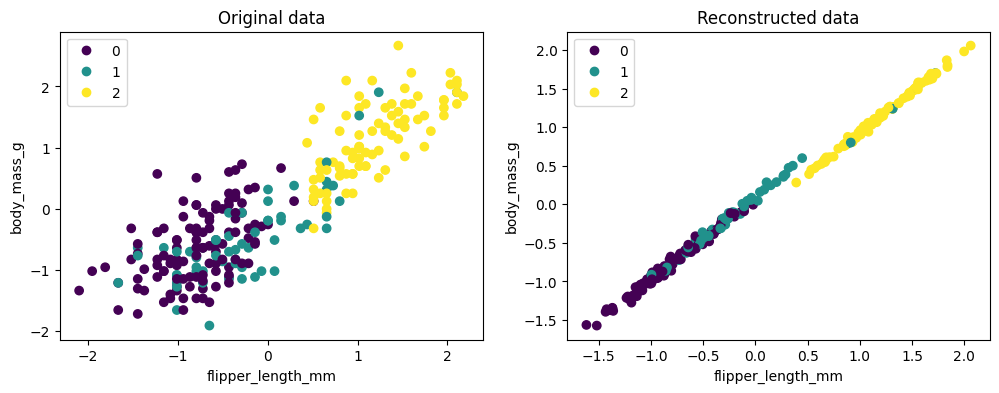

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# Plot the original data in 2D initial (flipper_length_mm - body_mass_g) space
scatter0 = axs[0].scatter(X_train.iloc[:, 2], X_train.iloc[:, 3], c=y_train, cmap='viridis')
axs[0].set(title='Original data', xlabel='flipper_length_mm', ylabel='body_mass_g')
axs[0].legend(*scatter0.legend_elements())
# Plot the reconstructed data in 2D initial (flipper_length_mm - body_mass_g) space
scatter1 = axs[1].scatter(X_train_reconstructed.iloc[:, 2], X_train_reconstructed.iloc[:, 3], c=y_train, cmap='viridis')
axs[1].set(title='Reconstructed data', xlabel='flipper_length_mm', ylabel='body_mass_g')
axs[1].legend(*scatter1.legend_elements());

## Limitation

PCA cannot separate data on a manifold (an N-dimensional shape) if they are bent and twisted into a higher dimensional shape: this is a limitation of the projection approach.

<img src="../images/pca_limitation.png" width="600" /><br />